# CPU to GPU

In [1]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15970463.94it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273685.09it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 889185.70it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10277142.79it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



In [4]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)

    return x

model = FMNIST()

In [6]:
# send model to GPU
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [7]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        # send images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 0.5077816355171234
Training loss: 0.46547431579785054
Training loss: 0.43943983108313606


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0
img = images[test_image_id].view(1, 784)

# although models are trained using GPU's , the testing and deployment happens in a CPU environment
# send model back to CPU for testing
model.to('cpu')

with torch.no_grad():
    logps = model(img)

In [9]:
ps = torch.exp(logps)
ps

tensor([[3.8938e-06, 5.8586e-07, 6.7269e-06, 1.7374e-06, 6.6115e-06, 9.5011e-02,
         1.0565e-05, 2.1414e-01, 7.5110e-03, 6.8331e-01]])

In [10]:
nps = ps.numpy()[0]
nps

array([3.8938101e-06, 5.8585641e-07, 6.7269384e-06, 1.7374036e-06,
       6.6115213e-06, 9.5010996e-02, 1.0565242e-05, 2.1413857e-01,
       7.5109866e-03, 6.8330944e-01], dtype=float32)

<BarContainer object of 10 artists>

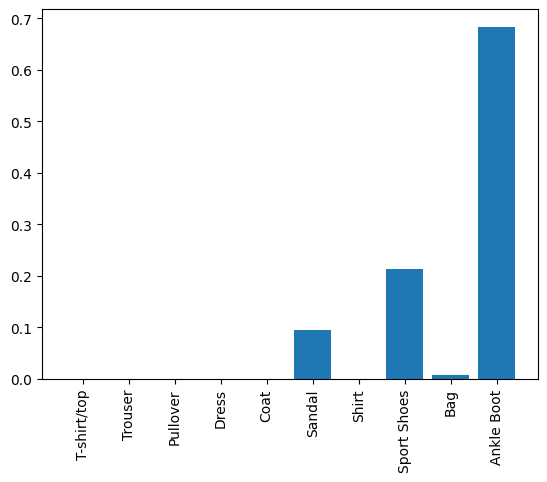

In [11]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

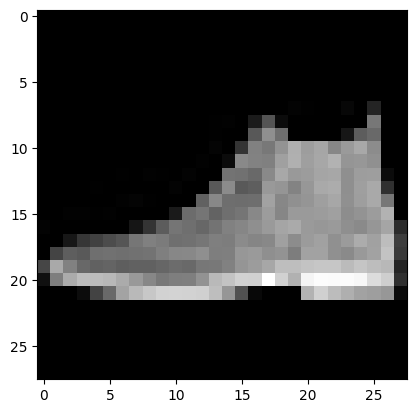

In [12]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor

img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

## Evaluation

In [14]:
with torch.no_grad():
  n_corr = 0
  total = 0

  count = 0
  for images, labels in testloader:

    logps = model(images)
    pred = torch.exp(logps)
    pred_class = torch.argmax(pred, 1)
    total += labels.size(0)
    count+=1

    if count > 0:
      break

In [16]:
pred_class, labels

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 0, 7, 7, 7,
         1, 2, 6, 0, 9, 4, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 9, 6, 7, 2, 1,
         2, 6, 4, 2, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5]),
 tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
         1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
         2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5]))

In [17]:
print(f'acc: {(pred_class == labels).sum()/total}')

acc: 0.8125


In [19]:
total

64